In [1]:
#data essentials
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import scipy

#self created tools
from getting_data import *
from Indicators import *
from y_engineering import *
from metric import *
from models import *

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

#sklearn
from sklearn.metrics import *

#visualisation with tensorboard
from torch.utils.tensorboard import SummaryWriter

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#use gpu if available
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = "cuda"

In [4]:
tickers = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA"]

In [5]:
# getting raw data
data = {}
for ticker in tickers:
    raw_path = "/home/jack/Desktop/Programming/tr_bot/data/train/" + ticker + "_train.csv"
    data[ticker] = pd.read_csv(raw_path)

In [7]:
# addig some features
#df['y_binary_sma4'] = (sma(df, period=4, column='Adj Close').shift(periods=-4) > df['Adj Close']).astype(int)
# df["ema_pct_20"] = pct_log(df, y_col='ema_20', time_to_pred = 1, pct=True, log=False)
# df["ema_pct_200"] = pct_log(df, y_col='ema_200', time_to_pred = 1, pct=True, log=False)

In [8]:
data[tickers[4]]

,Date,Open,High,Low,Close,Adj Close,Volume,pct,pct_log,ema_20,ema_50,ema_200,ema_pct_20,ema_pct_50,ema_pct_200,rsi_20,y_binary_sma4
0,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062823,308160000,NaN,NaN,0.062823,0.062823,0.062823,NaN,NaN,NaN,NaN,0
1,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063907,133171200,0.017255,-0.006182,0.063392,0.063376,0.063368,0.009059,0.008800,0.008671,NaN,0
2,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062281,67766400,-0.025443,0.009371,0.062984,0.062996,0.063002,-0.006436,-0.005990,-0.005774,NaN,0
3,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061198,47894400,-0.017389,0.006319,0.062468,0.062519,0.062544,-0.008187,-0.007570,-0.007266,NaN,0
4,1986-03-20,0.098090,0.098090,0.094618,0.095486,0.059574,58435200,-0.026537,0.009627,0.061768,0.061882,0.061938,-0.011208,-0.010191,-0.009689,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8837,2021-04-07,247.809998,250.929993,247.190002,249.899994,245.472717,22719800,0.008230,0.001492,234.537831,230.417240,211.750363,0.004932,0.002674,0.001603,0.117034,1
8838,2021-04-08,252.770004,254.139999,252.000000,253.250000,248.763367,23625200,0.013405,0.002420,235.892644,231.136696,212.118651,0.005777,0.003122,0.001739,0.137510,1
8839,2021-04-09,252.869995,255.990005,252.440002,255.850006,251.317322,24326800,0.010267,0.001852,237.361661,231.928093,212.508688,0.006227,0.003424,0.001839,0.152681,1
8840,2021-04-12,254.710007,257.670013,254.619995,255.910004,251.376266,27148700,0.000235,0.000042,238.696385,232.690766,212.895430,0.005623,0.003288,0.001820,0.153034,1


(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 4.000e+00,
        1.300e+01, 3.600e+01, 1.730e+02, 1.764e+03, 1.952e+03, 1.790e+02,
        3.800e+01, 1.200e+01, 8.000e+00, 3.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00]),
 array([-0.1 , -0.09, -0.08, -0.07, -0.06, -0.05, -0.04, -0.03, -0.02,
        -0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,
         0.08,  0.09,  0.1 ]),
 <BarContainer object of 20 artists>)

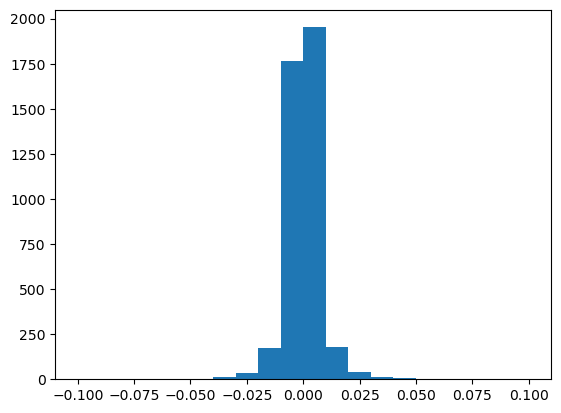

In [9]:
plt.hist(data[tickers[2]]["pct_log"], bins=20, range=(-0.1,0.1))

In [10]:
data[tickers[0]]["pct_log"].mean()

0.02648532590561872

In [11]:
# get all training and validation data and convert them to gpu

def convert_to_tensor(x):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return [torch.tensor(i).to(device).type(torch.cuda.FloatTensor) for i in x]

In [ ]:
#getting data for only one stock

# temp = get_xy(df, 14, x_col = ["pct_log"], y_col='y_binary_sma5', val_pct=0.2, period_to_skip=40)
# x_train, y_train, x_val, y_val = convert_to_tensor(temp)

# ind = get_xy(df, 14, x_col = ['ema_pct_21',"ema_pct_200", "rsi_20"], y_col='y_binary_sma5', val_pct=0.2, period_to_skip=40)
# ind_train, _, ind_val, _ = convert_to_tensor(ind)

In [12]:
#getting data for many stocks

def get_concatenated_xy(data, period=14, x_cols = [["pct_log"], ['ema_pct_20',"ema_pct_200", "rsi_20"]], y_col='y_binary_sma4', val_pct=0.2, period_to_skip=40):
    """
    takes in a dictionary data of all the different stocks and returns a concatenated form
    """
    
    x_train_concatenated = [ [] for _ in range(len(x_cols)) ]
    x_val_concatenated = [ [] for _ in range(len(x_cols)) ]
    y_train_concatenated = []
    y_val_concatenated = []
    
    for key, df in data.items():
        for i, x_col in enumerate(x_cols):
            temp = get_xy(df, period, x_col = x_col, y_col=y_col, val_pct=val_pct, period_to_skip=period_to_skip)
            x_train, y_train, x_val, y_val = convert_to_tensor(temp)
            
            x_train_concatenated[i].append(x_train)
            x_val_concatenated[i].append(x_val)
            
            
            if i == 0:
                y_train_concatenated.append(y_train)
                y_val_concatenated.append(y_val)
                
    return [torch.cat(x) for x in x_train_concatenated], [torch.cat(x) for x in x_val_concatenated], torch.cat(y_train_concatenated), torch.cat(y_val_concatenated)

In [13]:
x_train, x_val, y_train, y_val = get_concatenated_xy(data)

In [14]:
x_train[0].shape, x_train[1].shape, y_train.shape, y_val.shape

(torch.Size([25508, 1, 14]),
 torch.Size([25508, 3, 14]),
 torch.Size([25508, 1]),
 torch.Size([6441, 1]))

In [15]:
#turning data into a dataloader

batch_size = 64
x_train_ds = CustomDataset(x_train, y_train)
x_val_ds = CustomDataset(x_val, y_val)
train_dataloader = DataLoader(x_train_ds, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))
val_dataloader = DataLoader(x_val_ds, batch_size=batch_size, shuffle=True, generator=torch.Generator(device=device))

In [16]:
x_train_ds.Xs[1].size()

torch.Size([25508, 3, 14])

In [17]:
# some debugging to check where the nan values are
for i in range(3969):
    if x_train_ds.Xs[1][i:,:,:].isnan().sum()> 0:
        print(i)
        print(x_train_ds.Xs[1][i:,:,:])

In [18]:
#checking data shapes

temp = next(iter(train_dataloader))
len(temp), temp[0].shape, temp[1].shape, temp[2].shape

(3, torch.Size([64, 1, 14]), torch.Size([64, 3, 14]), torch.Size([64, 1]))

In [43]:
class indicator_cnn(nn.Module):
    """
    basic indicator model with 2 seperate cnn that that takes price and some indicators as input respectively. They both branch into a few common fully connected layers
    
    """
    
    
    def __init__(self):
        super(indicator_cnn, self).__init__()
        
        # direct price input layers
        # self.x_padding = nn.ConstantPad1d((0,2), 0)# we only want to pad the right because the earlier data is not as important
        self.x_conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=5, stride=2)
        self.x_conv2 = nn.Conv1d(6, 16, 3, 1)
        self.x_conv3 = nn.Conv1d(16, 24, 1)
        
        # indicators input layers
        # self.ind_padding = nn.ConstantPad1d((0,2), 0) # we only want to pad the right because the earlier data is not as important
        self.ind_conv1 = nn.Conv1d(in_channels=3, out_channels=6, kernel_size=5, stride=3)
        self.ind_conv2 = nn.Conv1d(6, 12, 3, 1)
        # self.ind_conv3 = nn.Conv1d(12, 16, 1, 1)
        
        #combined layers
        self.fc1 = nn.LazyLinear(40)
        self.fc2 = nn.Linear(40, 20)
        self.fc3 = nn.Linear(20, 1)
    
    def forward(self, x, ind):

        # x = self.x_padding(x)
        x = F.relu(self.x_conv1(x))
        x = nn.Dropout(0.2)(x)
        x = F.relu(self.x_conv2(x))
        x = nn.Dropout(0.2)(x)
        x = F.relu(self.x_conv3(x))
        x = nn.Dropout(0.2)(x)
        x = x.view(-1, self.num_flat_features(x))
        
        # ind = self.ind_padding(ind)
        ind = F.relu(self.ind_conv1(ind))
        ind = nn.Dropout(0.2)(ind)
        ind = F.relu(self.ind_conv2(ind))
        ind = nn.Dropout(0.2)(ind)
        # ind = F.relu(self.ind_conv3(ind))
        # ind = nn.Dropout(0.2)(ind)
        ind = ind.view(-1, self.num_flat_features(ind))
        
        combined = torch.cat((x, ind),1)
        combined = F.relu(self.fc1(combined))
        combined = F.relu(self.fc2(combined))
        combined = self.fc3(combined)
        
        return combined
    
    def predict(self, X, return_logits=True, threshold = 0.5):
        logits = torch.sigmoid(self.forward(*X).cpu().detach())
        if return_logits:
            return logits.numpy()
        return (logits > threshold).astype("int")
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def count_parameters(self):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    

model = indicator_cnn().cuda()

/home/jack/anaconda3/envs/trading_environment/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [44]:
#dry run to initialise lazy modules
model(*next(iter(train_dataloader))[:-1])

tensor([[0.0393],
        [0.0511],
        [0.0455],
        [0.0436],
        [0.0522],
        [0.0423],
        [0.0455],
        [0.0454],
        [0.0443],
        [0.0438],
        [0.0380],
        [0.0416],
        [0.0424],
        [0.0453],
        [0.0471],
        [0.0464],
        [0.0474],
        [0.0479],
        [0.0428],
        [0.0441],
        [0.0443],
        [0.0439],
        [0.0452],
        [0.0469],
        [0.0436],
        [0.0457],
        [0.0474],
        [0.0461],
        [0.0500],
        [0.0364],
        [0.0496],
        [0.0479],
        [0.0391],
        [0.0427],
        [0.0457],
        [0.0384],
        [0.0407],
        [0.0483],
        [0.0534],
        [0.0487],
        [0.0429],
        [0.0470],
        [0.0499],
        [0.0466],
        [0.0425],
        [0.0473],
        [0.0450],
        [0.0431],
        [0.0480],
        [0.0421],
        [0.0460],
        [0.0504],
        [0.0468],
        [0.0411],
        [0.0456],
        [0

In [45]:
#len(next(iter(train_dataloader))[:-1])

In [46]:
model.count_parameters()

5793

In [47]:
print(model)

indicator_cnn(
  (x_conv1): Conv1d(1, 6, kernel_size=(5,), stride=(2,))
  (x_conv2): Conv1d(6, 16, kernel_size=(3,), stride=(1,))
  (x_conv3): Conv1d(16, 24, kernel_size=(1,), stride=(1,))
  (ind_conv1): Conv1d(3, 6, kernel_size=(5,), stride=(3,))
  (ind_conv2): Conv1d(6, 12, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=96, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)


In [48]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas = (0.9, 0.999), weight_decay=1e-5)
# optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)

In [49]:
# using tensorboard visualisation tool
# To view, start TensorBoard on the command line with:
#tensorboard --logdir=runs
#and open a browser tab to http://localhost:6006/
from datetime import datetime

writer = SummaryWriter('runs/indicator_cnn_dropout')
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

In [50]:
# debugging each individual layers
def printnorm(self, input, output):
    # input is a tuple of packed inputs
    # output is a Tensor. output.data is the Tensor we are interested
    print('Inside ' + self.__class__.__name__ + ' forward')
    print('')
    print('input: ', type(input))
    print('input[0]: ', type(input[0]))
    print('output: ', type(output))
    print('')
    print('input size:', input[0].size())
    print('output size:', output.data.size())
    print('how many nan value:', torch.sum(torch.isnan(output.data)))

In [51]:
# register hooks to look at outputs for debugging

# model.x_conv3.register_forward_hook(printnorm)
# model.ind_conv2.register_forward_hook(printnorm)
# model.fc1.register_forward_hook(printnorm)

In [52]:
#model(*next(iter(train_dataloader))[:-1])

In [53]:
#training
epochs = 50

for t in range(epochs):
    print(f"Epoch {t+1} ------------------------>  ", end='')
    avg_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    avg_vloss, correct = test_loop(val_dataloader, model, loss_fn, batch_size=64)
    
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    t + 1)
    writer.flush()
print("Done!")

Epoch 1 ------------------------>  Avg training loss: 0.010808, Avg val loss: 0.010717, Validation accuracy: 58.6% 

Epoch 2 ------------------------>  Avg training loss: 0.010809, Avg val loss: 0.010746, Validation accuracy: 58.6% 

Epoch 3 ------------------------>  Avg training loss: 0.010805, Avg val loss: 0.010748, Validation accuracy: 58.6% 

Epoch 4 ------------------------>  Avg training loss: 0.010802, Avg val loss: 0.010712, Validation accuracy: 58.6% 

Epoch 5 ------------------------>  Avg training loss: 0.010801, Avg val loss: 0.010722, Validation accuracy: 58.6% 

Epoch 6 ------------------------>  Avg training loss: 0.010804, Avg val loss: 0.010715, Validation accuracy: 58.6% 

Epoch 7 ------------------------>  Avg training loss: 0.010802, Avg val loss: 0.010726, Validation accuracy: 58.6% 

Epoch 8 ------------------------>  Avg training loss: 0.010802, Avg val loss: 0.010752, Validation accuracy: 58.6% 

Epoch 9 ------------------------>  Avg training loss: 0.010799, 

In [54]:
logits = model.predict(x_val)
metric = anlayse_binary(logits, y_val.cpu().detach().numpy().astype("int"))

(array([   5.,   32.,  104.,  762., 2094., 1760.,  891.,  534.,  229.,
          30.]),
 array([0.46660107, 0.48035562, 0.49411017, 0.50786471, 0.52161926,
        0.53537381, 0.54912835, 0.5628829 , 0.57663745, 0.59039199,
        0.60414654]),
 <BarContainer object of 10 artists>)

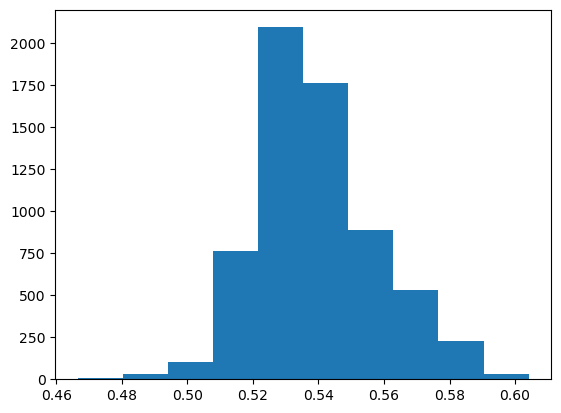

In [55]:
plt.hist(logits)

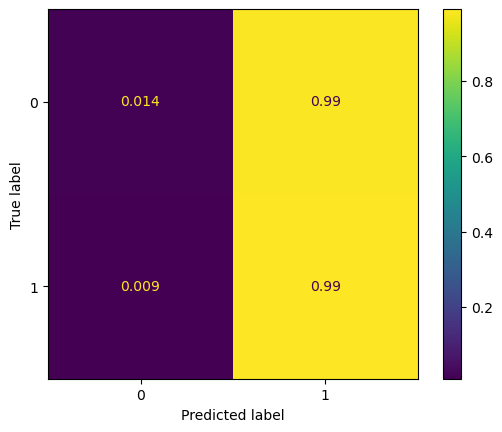

              precision    recall  f1-score   support

           0       0.52      0.01      0.03      2668
           1       0.59      0.99      0.74      3773

    accuracy                           0.59      6441
   macro avg       0.55      0.50      0.38      6441
weighted avg       0.56      0.59      0.44      6441



In [56]:
metric.binarise(0.50)
metric.show_cf()

In [57]:
metric.threshold_range(start=0.5,end=0.6)

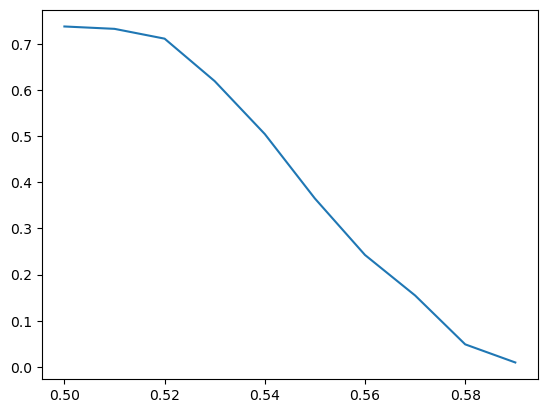

In [58]:
metric.graph_metric("f1-score")

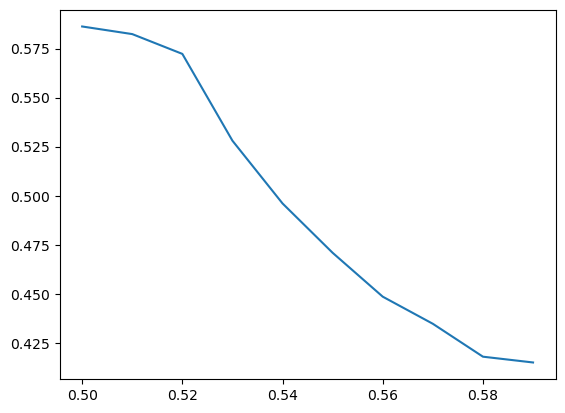

In [59]:
metric.graph_metric("accuracy")

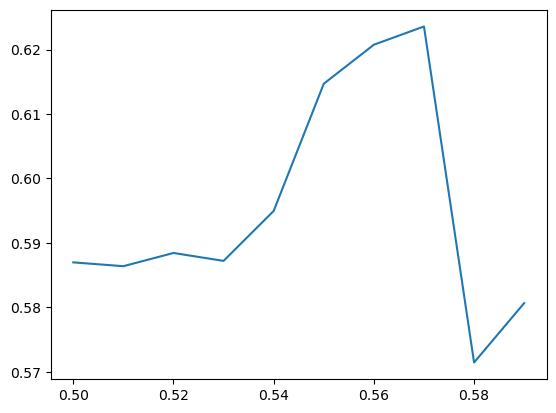

In [60]:
metric.graph_metric("precision")

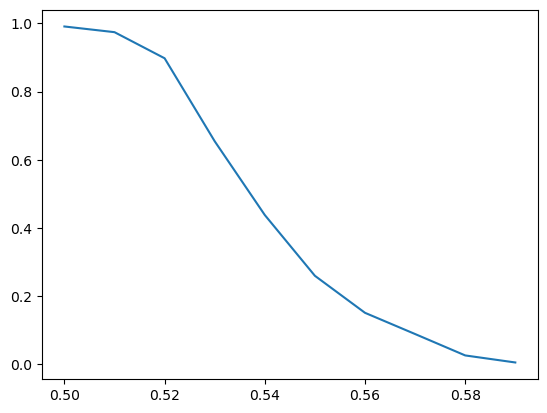

In [61]:
metric.graph_metric("recall")